In [1]:
import os
import email
import random
import email.policy
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import sklearn

In [2]:
# dataset link: https://www.kaggle.com/datasets/veleon/ham-and-spam-dataset
base_directory = "ham-and-spam-dataset/hamnspam/"
spam_email_names = os.listdir(base_directory + "spam")
normal_email_names = os.listdir(base_directory + "ham")

In [3]:
def load_email(is_spam, filename):
    directory = base_directory + ("spam" if is_spam else "ham")
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [4]:
spam_emails = [load_email(True, filename) for filename in spam_email_names]
normal_emails = [load_email(False, filename) for filename in normal_email_names]
random.shuffle(spam_emails)
random.shuffle(normal_emails)

In [6]:
def process_email(emails, label, data_dictionary, default_topic=None):
    for mail in emails:
        payload = mail.get_payload()
        if isinstance(payload, list):
            process_email(payload, label, data_dictionary, default_topic=mail["Subject"])
        else:
            if "Content-Type" in mail.keys():
                if "html" in mail["Content-Type"].lower():
                    try: 
                        soup = BeautifulSoup(mail.get_content())
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = soup.body.text
                        data_dictionary["topic"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                elif "plain" in mail["Content-Type"].lower():
                    try: 
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = mail.get_content()
                        data_dictionary["topic"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                else:
                    pass

In [7]:
data_dictionary = {"topic": [], "content": [], "label": []}
process_email(spam_emails, 1, data_dictionary)
process_email(normal_emails, 0, data_dictionary)
df = pd.DataFrame(data_dictionary)
df.dropna(inplace=True)
df = df.sample(frac=1)

In [8]:
df.head(10)

,topic,content,label
116,Attn: PROTECT YOURSELF AGAINST HARMFUL VIRUSES...,Here is an excerpt from your local newspaper. ...,1
2026,Re: Unseen window versus Sequences Window,> From: Hal DeVore <haldevore@acm.org>\n> Dat...,0
1966,[IMG: http://radio.weblogs.com/0001015/images/...,URL: http://scriptingnews.userland.com/backiss...,0
2630,Re[2]: Selling Wedded Bliss (was Re: Ouch...),"On Thu, 5 Sep 2002 bitbitch@magnesium.net wrot...",0
886,Re: /home/dude,"Once upon a time, Axel wrote :\n\n> I am now r...",0
741,Re: [zzzzteana] Nothing like mama used to make,Martin Adamson wrote:\n> \n> Isn't it just bas...,0
1308,Re: ALSA (almost) made easy,"On Thu, 2002-08-29 at 00:02, Ville Skyttä wrot...",0
1290,Re: [zzzzteana] The Cafe Forteana is back onli...,>That Goddess Chick wrote:\n>>\n>> >Thanks Fe...,0
2077,Freedom deal for Real IRA man,"URL: http://www.newsisfree.com/click/-0,859765...",0
159,Special Affiliate Offers from Amazon.Com!,"\n\n Welcome to ""Ghetto"" Ame...",1


<AxesSubplot:>

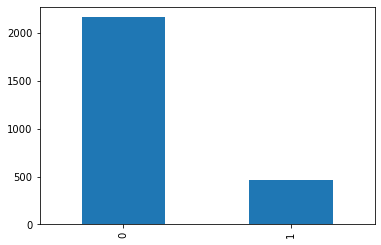

In [170]:
df["label"].value_counts().plot(kind="bar")

In [171]:
class_weight = 1 / df["label"].value_counts()
class_weight = dict(class_weight / class_weight.sum())
class_weight

{0: 0.1763809523809524, 1: 0.8236190476190477}

In [172]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
def preprocess_text(content):
    # Change text to lowercased
    content = content.lower()
    # Remove stop words
    for stopword in stopwords:
        content = content.replace(stopword + " ", "")
        content = content.replace(" " + stopword, "")
    return content

In [173]:
num_words = 8196
max_content_length = 512
topic_and_contents = []
for (topic, content) in zip(df["topic"], df["content"]):
    topic_and_contents.append(preprocess_text(topic + " " + content))
df["topic_content"] = topic_and_contents
tokenizer = Tokenizer(num_words=num_words - 1, oov_token="<OOV>")
tokenizer.fit_on_texts(topic_and_contents)

In [174]:
df.head()

,topic,content,label,topic_content
1430,Re: Selling Wedded Bliss (was Re: Ouch...),Eugen Leitl:\n>Clearly our non-silly non-antiq...,0,re: sellingdded bliss (wre: ouch...) eugen lei...
1113,Sun donates elliptic curve code to OpenSSL? (fwd),---------- Forwarded message ----------\nDate:...,0,sunnates elliptic curve code openssl? (fwd) --...
1214,Play by Play: Effective Memory Management,"URL: http://www.newsisfree.com/click/-6,650303...",0,play play: effectivemory management url: http:...
2106,Re: Computational Recreations,"On Monday, August 26, 2002, at 09:59 AM, Tom ...",0,"re: computational recreations monday,ugust 26,..."
1132,California needs intelligent energy deregulation,\n--- begin forwarded text\n\n\nStatus: RO\nDa...,0,californineedsntelligent energy deregulati\n--...


In [175]:
tokenized_topic_and_contents = tokenizer.texts_to_sequences(topic_and_contents)

In [176]:
tokenized_topic_and_content_lengths = pd.DataFrame([len(item) for item in tokenized_topic_and_contents])

In [177]:
tokenized_topic_and_content_lengths.describe()

,0
count,2625.000000
mean,142.969905
std,281.633032
min,2.000000
25%,50.000000
50%,89.000000
75%,147.000000
max,6758.000000


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

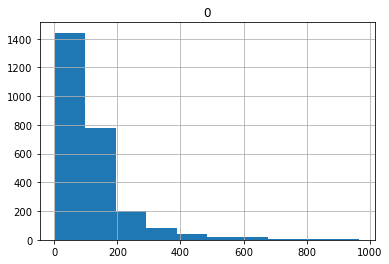

In [178]:
tokenized_topic_and_content_lengths[tokenized_topic_and_content_lengths < 1024].hist()

In [179]:
padding_tokenized_topic_and_contents = pad_sequences(
    tokenized_topic_and_contents, 
    padding='post', 
    truncating='post', 
    maxlen=max_content_length
)

In [180]:
X = np.array(padding_tokenized_topic_and_contents)
y = np.array(df["label"])
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2231, 512), (394, 512), (2231,), (394,))

In [181]:
from evalml.automl import AutoMLSearch
auto = AutoMLSearch(X,y,problem_type='binary',max_batches=1,optimize_thresholds=True)
auto.search()

In [22]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 256, input_length=max_content_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 256)          2098176   
                                                                 
 bidirectional (Bidirectiona  (None, 512, 256)         394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [23]:
checkpoint_path = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), class_weight=class_weight, epochs=10, callbacks=[checkpoint])
model.load_weights(checkpoint_path)

Epoch 1/10
70/70 [==============================] - 119s 2s/step - loss: 0.1315 - accuracy: 0.8100 - val_loss: 0.1028 - val_accuracy: 0.9619
Epoch 2/10
70/70 [==============================] - 117s 2s/step - loss: 0.0275 - accuracy: 0.9682 - val_loss: 0.0416 - val_accuracy: 0.9772
Epoch 3/10
70/70 [==============================] - 119s 2s/step - loss: 0.0110 - accuracy: 0.9816 - val_loss: 0.0426 - val_accuracy: 0.9822
Epoch 4/10
70/70 [==============================] - 122s 2s/step - loss: 0.0081 - accuracy: 0.9910 - val_loss: 0.0138 - val_accuracy: 0.9949
Epoch 5/10
70/70 [==============================] - 121s 2s/step - loss: 0.0031 - accuracy: 0.9924 - val_loss: 0.0087 - val_accuracy: 0.9949
Epoch 6/10
70/70 [==============================] - 130s 2s/step - loss: 0.0096 - accuracy: 0.9928 - val_loss: 0.6236 - val_accuracy: 0.9188
Epoch 7/10
70/70 [==============================] - 128s 2s/step - loss: 0.0065 - accuracy: 0.9928 - val_loss: 0.0319 - val_accuracy: 0.9898
Epoch 8/10
70

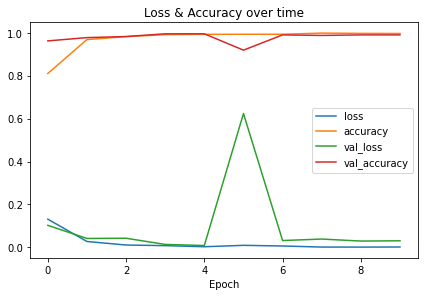

In [73]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(xlabel="Epoch")
plt.autoscale()
plt.tight_layout()
plt.title("Loss & Accuracy over time")

In [119]:
y_pred = np.argmax(model.predict(X_test), axis=1)

13/13 [==============================] - 5s 354ms/step


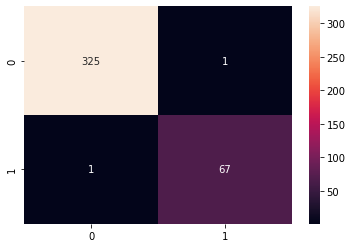

In [120]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [121]:
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)


In [122]:
cls_report = sklearn.metrics.classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       326
           1       0.99      0.99      0.99        68

    accuracy                           0.99       394
   macro avg       0.99      0.99      0.99       394
weighted avg       0.99      0.99      0.99       394



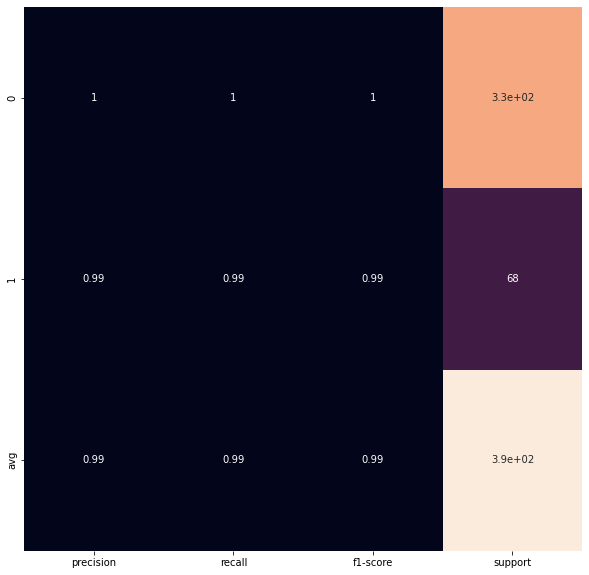

In [123]:
plot_classification_report(y_test, y_pred)